# Laboratorio 2 - Parte 3
## Cifrado de Información
### José Daniel Gómez Cabrera 21429

In [23]:
import time
import os
import psutil
import matplotlib.pyplot as plt
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives import padding
from cryptography.hazmat.backends import default_backend
import numpy as np

### Implementar ChaCha20 para cifrar y descifrar mensajes.

In [24]:
def encrypt_chacha20(mensaje, key, nonce):
    """Cifra un mensaje usando ChaCha20"""
    algorithm = algorithms.ChaCha20(key, nonce)
    cipher = Cipher(algorithm, mode=None, backend=default_backend())
    encryptor = cipher.encryptor()
    return encryptor.update(mensaje)

def decrypt_chacha20(cifrado, key, nonce):
    """Descifra un mensaje usando ChaCha20"""
    algorithm = algorithms.ChaCha20(key, nonce)
    cipher = Cipher(algorithm, mode=None, backend=default_backend())
    decryptor = cipher.decryptor()
    return decryptor.update(cifrado)

### Comparar su rendimiento con AES en tiempos y consumo de memoria.

#### Cifrar con AES

In [25]:
def encrypt_aes(mensaje, key, iv):
    padder = padding.PKCS7(128).padder()
    padded_data = padder.update(mensaje) + padder.finalize()

    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
    encryptor = cipher.encryptor()
    return encryptor.update(padded_data) + encryptor.finalize()

def decrypt_aes(cifrado, key, iv):
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
    decryptor = cipher.decryptor()
    padded_data = decryptor.update(cifrado) + decryptor.finalize()

    unpadder = padding.PKCS7(128).unpadder()
    return unpadder.update(padded_data) + unpadder.finalize()

In [26]:
# podemos medir el consumo de memoria
def measure_memory():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024

In [27]:
# bench marks para poder medir el rendimiento
def benchmark(tamanos_mensaje):
    resultados = {
        'tamaños': tamanos_mensaje,
        'chacha20_tiempo_cifrado': [],
        'chacha20_tiempo_descifrado': [],
        'chacha20_memoria_cifrado': [],
        'chacha20_memoria_descifrado': [],
        'aes_tiempo_cifrado': [],
        'aes_tiempo_descifrado': [],
        'aes_memoria_cifrado': [],
        'aes_memoria_descifrado': [],
    }

    chacha20_key = os.urandom(32)  # 256 bits
    chacha20_nonce = os.urandom(16)  # 128 bits

    aes_key = os.urandom(32)  # AES-256
    aes_iv = os.urandom(16)  # 128 bits

    for tamano in tamanos_mensaje:
        # mensajes aleatorios
        mensaje = os.urandom(tamano)

        print(f"Probando con mensaje de {tamano} bytes")

        # cifrado del chacha20
        memoria_antes = measure_memory()
        inicio = time.time()
        cifrado_chacha = encrypt_chacha20(mensaje, chacha20_key, chacha20_nonce)
        fin = time.time()
        memoria_despues = measure_memory()

        resultados['chacha20_tiempo_cifrado'].append(fin - inicio)
        resultados['chacha20_memoria_cifrado'].append(memoria_despues - memoria_antes)

        # descrifrado del cha cha 20
        memoria_antes = measure_memory()
        inicio = time.time()
        decrypt_chacha20(cifrado_chacha, chacha20_key, chacha20_nonce)
        fin = time.time()
        memoria_despues = measure_memory()

        resultados['chacha20_tiempo_descifrado'].append(fin - inicio)
        resultados['chacha20_memoria_descifrado'].append(memoria_despues - memoria_antes)

        # cifrado del aes
        memoria_antes = measure_memory()
        inicio = time.time()
        cifrado_aes = encrypt_aes(mensaje, aes_key, aes_iv)
        fin = time.time()
        memoria_despues = measure_memory()

        resultados['aes_tiempo_cifrado'].append(fin - inicio)
        resultados['aes_memoria_cifrado'].append(memoria_despues - memoria_antes)

        # descrifrado del aes
        memoria_antes = measure_memory()
        inicio = time.time()
        decrypt_aes(cifrado_aes, aes_key, aes_iv)
        fin = time.time()
        memoria_despues = measure_memory()

        resultados['aes_tiempo_descifrado'].append(fin - inicio)
        resultados['aes_memoria_descifrado'].append(memoria_despues - memoria_antes)

    return resultados

In [28]:
def graficar_resultados(resultados):
    tamanos_mb = [t / (1024 * 1024) for t in resultados['tamaños']]

    # Gráfico de tiempo de cifrado con  ChaCha20 y AES
    plt.figure(figsize=(12, 6))
    plt.plot(tamanos_mb, resultados['chacha20_tiempo_cifrado'], 'b-', label='ChaCha20')
    plt.plot(tamanos_mb, resultados['aes_tiempo_cifrado'], 'r-', label='AES')
    plt.title('Tiempo de cifrado vs. Tamaño del mensaje')
    plt.xlabel('Tamaño del mensaje (MB)')
    plt.ylabel('Tiempo (segundos)')
    plt.legend()
    plt.grid(True)
    plt.savefig('tiempo_cifrado.png')

    # Gráfico de tiempo de descifrado con  ChaCha20 y AES
    plt.figure(figsize=(12, 6))
    plt.plot(tamanos_mb, resultados['chacha20_tiempo_descifrado'], 'b-', label='ChaCha20')
    plt.plot(tamanos_mb, resultados['aes_tiempo_descifrado'], 'r-', label='AES')
    plt.title('Tiempo de descifrado vs. Tamaño del mensaje')
    plt.xlabel('Tamaño del mensaje (MB)')
    plt.ylabel('Tiempo (segundos)')
    plt.legend()
    plt.grid(True)
    plt.savefig('tiempo_descifrado.png')

    # Gráfico de uso de memoria en cifrado con  ChaCha20 y AES
    plt.figure(figsize=(12, 6))
    plt.plot(tamanos_mb, resultados['chacha20_memoria_cifrado'], 'b-', label='ChaCha20')
    plt.plot(tamanos_mb, resultados['aes_memoria_cifrado'], 'r-', label='AES')
    plt.title('Uso de memoria en cifrado vs. Tamaño del mensaje')
    plt.xlabel('Tamaño del mensaje (MB)')
    plt.ylabel('Memoria (MB)')
    plt.legend()
    plt.grid(True)
    plt.savefig('memoria_cifrado.png')

    # Gráfico de uso de memoria en descifrado con  ChaCha20 y AES
    plt.figure(figsize=(12, 6))
    plt.plot(tamanos_mb, resultados['chacha20_memoria_descifrado'], 'b-', label='ChaCha20')
    plt.plot(tamanos_mb, resultados['aes_memoria_descifrado'], 'r-', label='AES')
    plt.title('Uso de memoria en descifrado vs. Tamaño del mensaje')
    plt.xlabel('Tamaño del mensaje (MB)')
    plt.ylabel('Memoria (MB)')
    plt.legend()
    plt.grid(True)
    plt.savefig('memoria_descifrado.png')

#### Ejemplo

Mensaje original: Este es un mensaje secreto que quiero cifrar

Cifrado ChaCha20: d134e57162ee70993d6df92eb2a5dbef09fef590cd560978f9
Descifrado ChaCha20: Este es un mensaje secreto que quiero cifrar

Cifrado AES: 44806d050f2cbe1119ebb35c9b3244d4e0f619dbe9c1ddd0dc
Descifrado AES: Este es un mensaje secreto que quiero cifrar

Comparando rendimiento de ChaCha20 vs AES
Probando con mensaje de 1024 bytes
Probando con mensaje de 10240 bytes
Probando con mensaje de 102400 bytes
Probando con mensaje de 1048576 bytes
Probando con mensaje de 10485760 bytes

--- Resultados de rendimiento ---

Tiempo promedio de cifrado (segundos):
ChaCha20: 0.001238
AES: 0.001998

Tiempo promedio de descifrado (segundos):
ChaCha20: 0.001035
AES: 0.002787

Uso de memoria promedio en cifrado (MB):
ChaCha20: 4.487500
AES: 2.231250

Uso de memoria promedio en descifrado (MB):
ChaCha20: 2.156250
AES: 2.234375


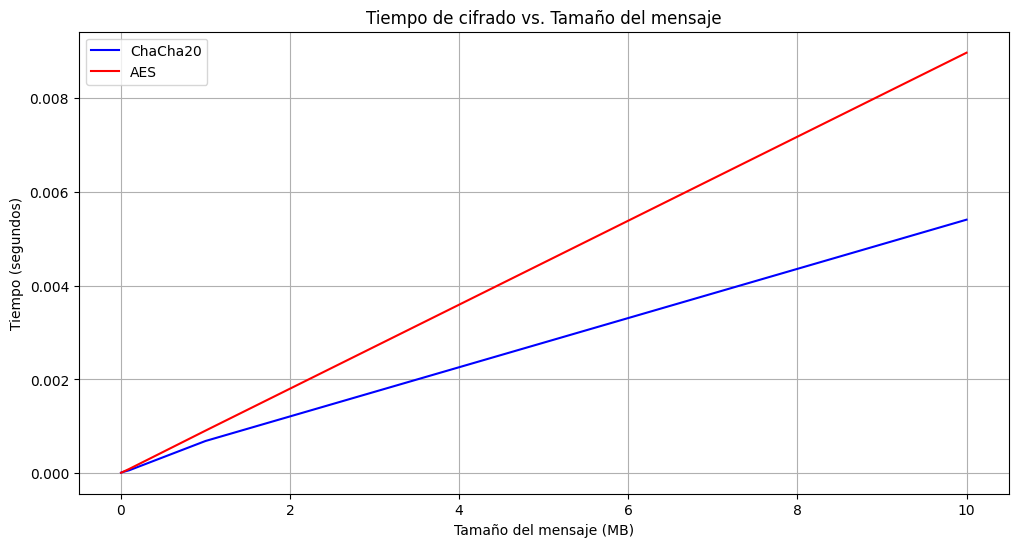

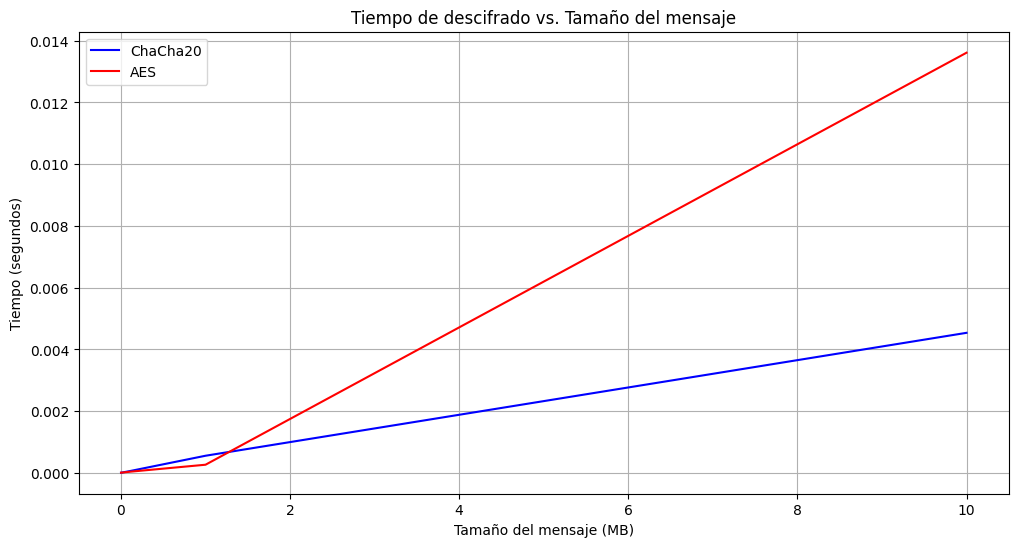

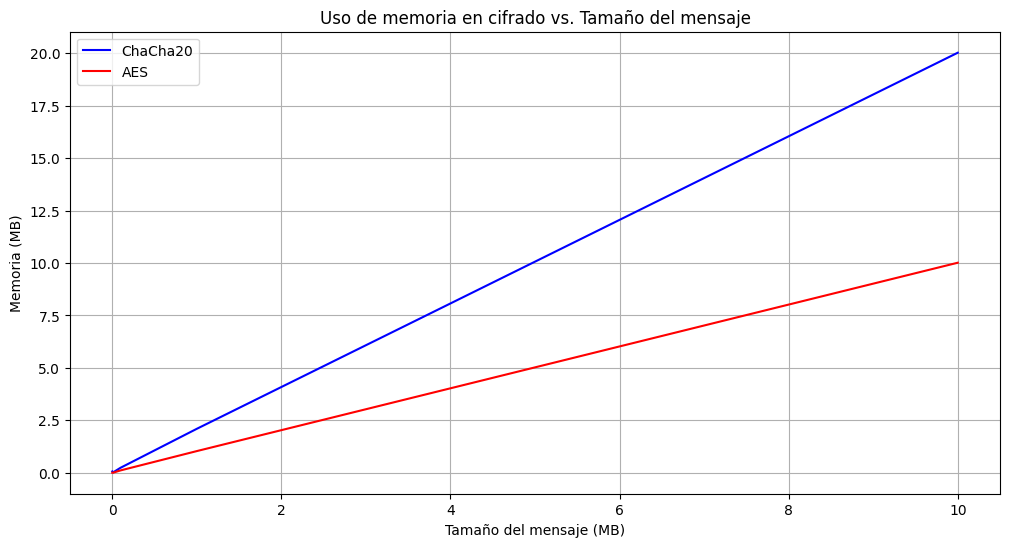

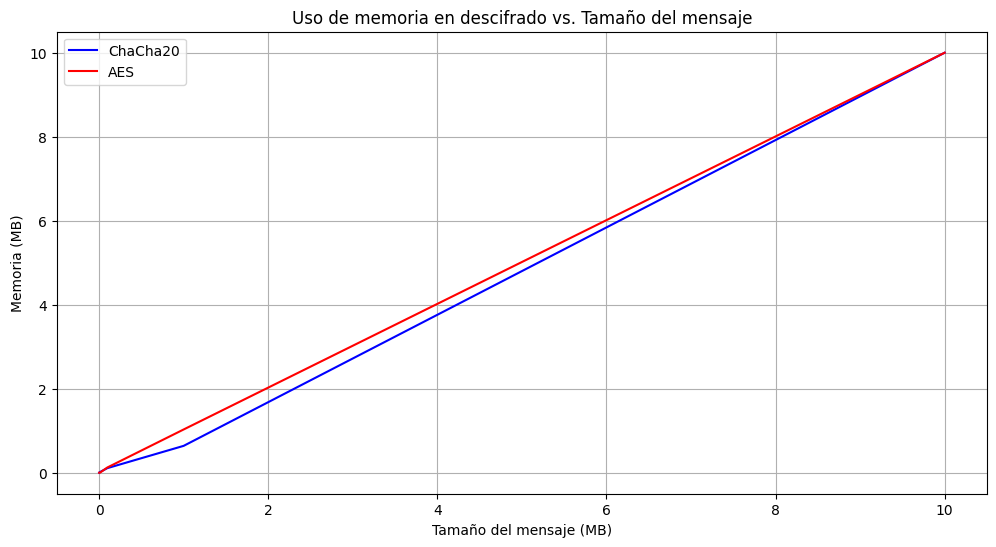

In [29]:
mensaje = b"Este es un mensaje secreto que quiero cifrar"
print(f"Mensaje original: {mensaje.decode('utf-8')}")

# ChaCha20
chacha20_key = os.urandom(32)
chacha20_nonce = os.urandom(16)

cifrado_chacha = encrypt_chacha20(mensaje, chacha20_key, chacha20_nonce)
descifrado_chacha = decrypt_chacha20(cifrado_chacha, chacha20_key, chacha20_nonce)

print(f"\nCifrado ChaCha20: {cifrado_chacha.hex()[:50]}")
print(f"Descifrado ChaCha20: {descifrado_chacha.decode('utf-8')}")

# AES
aes_key = os.urandom(32)
aes_iv = os.urandom(16)

cifrado_aes = encrypt_aes(mensaje, aes_key, aes_iv)
descifrado_aes = decrypt_aes(cifrado_aes, aes_key, aes_iv)

print(f"\nCifrado AES: {cifrado_aes.hex()[:50]}")
print(f"Descifrado AES: {descifrado_aes.decode('utf-8')}")

print("\nComparando rendimiento de ChaCha20 vs AES")
# Tamaños de mensaje en bytes para la prueba: 1KB, 10KB, 100KB, 1MB, 10MB
tamanos_mensaje = [1024, 10*1024, 100*1024, 1024*1024, 10*1024*1024]
resultados = benchmark(tamanos_mensaje)

print("\n--- Resultados de rendimiento ---")
print("\nTiempo promedio de cifrado (segundos):")
print(f"ChaCha20: {np.mean(resultados['chacha20_tiempo_cifrado']):.6f}")
print(f"AES: {np.mean(resultados['aes_tiempo_cifrado']):.6f}")

print("\nTiempo promedio de descifrado (segundos):")
print(f"ChaCha20: {np.mean(resultados['chacha20_tiempo_descifrado']):.6f}")
print(f"AES: {np.mean(resultados['aes_tiempo_descifrado']):.6f}")

print("\nUso de memoria promedio en cifrado (MB):")
print(f"ChaCha20: {np.mean(resultados['chacha20_memoria_cifrado']):.6f}")
print(f"AES: {np.mean(resultados['aes_memoria_cifrado']):.6f}")

print("\nUso de memoria promedio en descifrado (MB):")
print(f"ChaCha20: {np.mean(resultados['chacha20_memoria_descifrado']):.6f}")
print(f"AES: {np.mean(resultados['aes_memoria_descifrado']):.6f}")

graficar_resultados(resultados)